# Image Classifier

Refer to 01_intro.ipynb and 02_production.ipynb for details.

In [1]:
from fastai.vision.all import *

## Quick Model

In [3]:
path = Path('data')

# Our x are images, our y is a category. We'll resize all images initially to 128x128. The label for each image can be
# determined from its parent folder. We'll apply an 80/20 training/validation split.
faces = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = faces.dataloaders(path)

In [18]:
# Finetune an Imagenet-trained resnet18 model where once epoch is run with the last layer unfrozen, then the rest of the
# network is unfrozen for 4 epochs.
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.400627,0.638771,0.710145,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.636964,0.238934,0.884058,00:03
1,0.508803,0.250695,0.927536,00:05
2,0.390764,0.271932,0.942029,00:04
3,0.328277,0.264101,0.942029,00:04


## Improving the Model with Resizing and Augmentations

In [19]:
# Use random resized crop so a different part of the image is focused on with each epoch
# Results are worse suggesting we're losing important data by cropping.
faces = faces.new(item_tfms=RandomResizedCrop(128, min_scale=0.5))
dls = faces.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.066720,0.409224,0.840580,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.652061,0.315162,0.869565,00:05
1,0.491158,0.309270,0.898551,00:04
2,0.380984,0.273859,0.927536,00:04
3,0.322465,0.270173,0.927536,00:04


In [20]:
# Since randomized crop produced worse result, we go with resizing with squishing/streteching allowed so
# that we don't lose data and all pixels are represented in some way
# We get an error rate similar to the original case
faces = faces.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = faces.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.259792,0.517713,0.826087,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.616555,0.402361,0.855072,00:05
1,0.457523,0.298578,0.898551,00:04
2,0.317921,0.251039,0.913043,00:05
3,0.244738,0.246268,0.927536,00:04


In [21]:
# Try data augmentation - Rotation, flipping, warping, brightness changes, contrast changes
# Results declined
faces = faces.new(item_tfms=Resize(128, ResizeMethod.Squish), batch_tfms=aug_transforms())
dls = faces.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.371634,0.646815,0.753623,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.652111,0.452847,0.840580,00:04
1,0.571619,0.406979,0.869565,00:05
2,0.443076,0.350106,0.855072,00:05
3,0.365055,0.301000,0.869565,00:04


In [22]:
# Since squishing wasn't clearly better than a normal resize, we try a normal resize along with
# augmentation.
# We get 93% accuracy
faces = faces.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = faces.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.202318,0.369461,0.884058,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.677587,0.214881,0.898551,00:04
1,0.594762,0.149296,0.942029,00:04
2,0.488187,0.173700,0.927536,00:05
3,0.413810,0.168024,0.927536,00:05


In [4]:
# We return to using squish resizing so full data is included. But this time we use a deeper network as well.
# Resnet model we could use are: resnet18, resnet34, resnet50, resnet101, resnet152
# resnet34 produces slightly worse results
faces = faces.new(item_tfms=Resize(128, ResizeMethod.Squish), batch_tfms=aug_transforms())
dls = faces.dataloaders(path)
# We reduce the batch-size to ensure the model can be trained on the GPU
learn = cnn_learner(dls, resnet34, metrics=accuracy, bs=32)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.360550,0.653013,0.800000,00:06


/home/bluelight/envs/image_classifier_env/lib/python3.6/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,accuracy,time
0,0.303443,0.286775,0.912000,00:07
1,0.221343,0.165196,0.952000,00:07
2,0.162086,0.126161,0.976000,00:06
3,0.131050,0.133373,0.976000,00:07


/home/bluelight/envs/image_classifier_env/lib/python3.6/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/bluelight/envs/image_classifier_env/lib/python3.6/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/bluelight/envs/image_classifier_env/lib/python3.6/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/bluelight/envs/image_classifier_env/lib/python3.6/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed i

In [24]:
# We return to using the model producing the best results after 2 epochs where a normal resize
# and augmentation transforms are applied
# This time, we also use set_seed to get reproducible results
set_seed(42, True)
faces = faces.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = faces.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.235793,0.827627,0.666667,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.700897,0.210412,0.898551,00:04
1,0.581560,0.126296,0.971014,00:05
2,0.463669,0.133857,0.971014,00:05
3,0.396687,0.146669,0.956522,00:05


## Cleaning

In [14]:
# Can show some images, select which ones to delete, then run the deletion code in the cell below
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
# Once we've selected images to delete, run the line below to have them deleted
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# This line takes care of moving images between categories
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Saving and Loading

In [44]:
# We return to using the model producing the best results where a normal resize
# and augmentation transforms are applied
# This time, we have cleaner data as well. We get 96% error after all epochs though 97% after the 2nd and 3rd epoch.
set_seed(42, True)
faces = faces.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = faces.dataloaders(path)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.235793,0.827627,0.666667,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.700897,0.210412,0.898551,00:05
1,0.581560,0.126296,0.971014,00:05
2,0.463669,0.133857,0.971014,00:05
3,0.396687,0.146669,0.956522,00:05


In [45]:
# Save model
model_path = Path("models")/"male_vs_female_face_classifier.pkl"
learn.export(model_path)

# Load and use the model
learn_inf = load_learner(model_path)
print("Classes:", learn_inf.dls.vocab)
predicted_class, predicted_class_index, pred_probs = learn_inf.predict("data/male/image.jpeg")
print("Predicted Class:", predicted_class)

Classes: (#2) ['female','male']


Predicted Class: male


## Treating as a MultiLabel Problem

In [2]:
path = Path('data')

# Ensure reproducibility of results
set_seed(42, True)

# To treat the problem as a multilabel classification problem, we provide y as a list
# indicating all the applicable categories, if any.
def get_y_labels(file):
    return [parent_label(file)]

faces = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y_labels,
    item_tfms=Resize(128), batch_tfms=aug_transforms())

dls = faces.dataloaders(path)

# We use multi-accuracy which computes the accuracy rate across labels
learn = cnn_learner(dls, resnet18, metrics=accuracy_multi)

In [ ]:
learn.fine_tune(4)

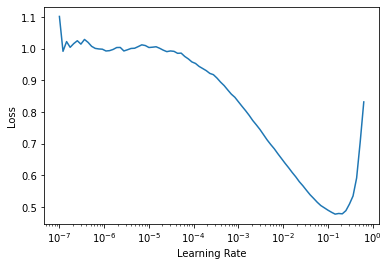

In [6]:
# Ensure reproducibility of results
set_seed(42, True)

# Identify an optimal learning rate - use the steep learning rate
lr_candidates = learn.lr_find()

In [12]:
 lr_candidates.lr_steep, lr_candidates.lr_min/10

(0.00363078061491251, 0.003, 0.0014454397559165953, 0.001)

In [3]:
# Train and Save model LR-optimized model

# Ensure reproducibility of results
set_seed(42, True)
# learn.fine_tune(4, lr_candidates.lr_steep)
learn.fine_tune(4, 1e-3)
model_path = Path("models")/"male_vs_female_face_classifier.pkl"
learn.export(model_path)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.886078,0.708721,0.725490,00:05


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.495140,0.370487,0.840336,00:06
1,0.422499,0.215489,0.913165,00:06
2,0.365326,0.177833,0.929972,00:06
3,0.320023,0.168760,0.938375,00:07


In [4]:
# Load and use the model
model_path = Path("models")/"male_vs_female_face_classifier.pkl"
learn_inf = load_learner(model_path)
print("Labels:", learn_inf.dls.vocab)
predicted_labels, predicted_label_mask, pred_probs = learn_inf.predict("data/male/image.jpeg")
print("Predicted Labels:", predicted_labels)

Labels: (#3) ['female','male','misc']


Predicted Labels: (#1) ['male']
